# Mask R-CNN, resnet101 backbone, coco weights with training All Layers

In [1]:
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [2]:
import boto3, re
from sagemaker import get_execution_role
role = get_execution_role()

In [3]:
import tensorflow
print(tensorflow.__version__)


1.15.2


In [4]:
#!pip install keras==2.2.4

In [5]:
import keras
print(keras.__version__)

2.2.4


Using TensorFlow backend.


In [6]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 11.9MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!pip install mlxtend  

     |████████████████████████████████| 1.3MB 17.1MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
#installing the MaskRCNN 
!pip install mrcnn

     |████████████████████████████████| 61kB 11.4MB/s eta 0:00:01
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54938 sha256=33e970de230e062103bf1d7c53f6f177710cf9fe67d00979fd30ae7f8cd39d0d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
!pip3 install imgaug

     |████████████████████████████████| 952kB 15.3MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 56.3MB/s eta 0:00:01
     |████████████████████████████████| 12.4MB 58.1MB/s eta 0:00:01
     |████████████████████████████████| 133kB 87.0MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 75.2MB/s eta 0:00:01
  Found existing installation: PyWavelets 0.5.2
    Uninstalling PyWavelets-0.5.2:
      Successfully uninstalled PyWavelets-0.5.2
  Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
!pip install tqdm

     |████████████████████████████████| 71kB 15.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
#Importing the Required Packages
import keras
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import io
import os
import pathlib
import glob
import time
from mrcnn.config import Config 
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize

from boto3 import client
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO


In [12]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [13]:
root_path = 'sagemaker-capstone-pd'
train_dicom_dir = 'pneumonia-dataset/stage_2_train_images/'
train_lables_filename = 'pneumonia-dataset/stage_2_train_labels.csv'
dicom_images_path_filename = 'pneumonia-dataset/stage_2_images_path.csv'

In [14]:
def load_csv_file(path, filename):
  bucket = path
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  train_labels_df = pd.read_csv(data_location)
  return train_labels_df

In [15]:
def load_dicom_images_path(bkt , filename):

  print (' loading file name from  : ', bkt + '/' + filename)
  image_df = pd.DataFrame(columns=['path', 'patientId'])

  bucket = bkt
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  temp_df = pd.read_csv(data_location)
  
  i = 0  
  for ind in temp_df.index:
      dicom_folder_path = temp_df['path'][ind]
      dicom_image_filename = temp_df['filename'][ind]
      p_id = dicom_image_filename.split('.')[0]
      filepath = dicom_folder_path + dicom_image_filename
      image_df = image_df.append({'path': filepath, 'patientId': p_id}, ignore_index=True)
  
  return list(image_df.path)

In [16]:
# Functions to read the Dicom Directories and setting the annotations.
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(bkt, anns): 
    #image_fps = get_dicom_fps(dicom_dir)
    image_fps = load_dicom_images_path(bkt , dicom_images_path_filename)
     
    no_of_images = len(image_fps)
    image_annotations = {fp: [] for fp in image_fps}
   
    for index, row in anns.iterrows(): 
        #fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        fp = train_dicom_dir +  row['patientId']+'.dcm'
        image_annotations[fp].append(row)
    
    return image_fps, image_annotations

In [17]:
# Initialisation Config Files for the MASKRCNN 
class inputConfig():
    NUM_CLASSES = 2
    CLASS_DICT = {0: 'No Pneumonia', 1: 'Pneumonia with opacity'}
    CATEGORIES = list(CLASS_DICT.values())
    CATEGORIES_VALUES = list(CLASS_DICT.keys())


# Initialisation and config Files for Transfer Learning using the coco Weights.
class DetectorConfig_tf(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia_cocoweights_alllayers'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    #IMAGES_PER_GPU = 2
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #RPN_ANCHOR_SCALES = (64, 128,192)
    RPN_NMS_THRESHOLD  = 0.9
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3 
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.3
    #STEPS_PER_EPOCH = 500 
    STEPS_PER_EPOCH = 100
    TRAIN_BN =True 

config_tf = DetectorConfig_tf()
config_tf.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

In [18]:
# Functions for read Dicom files and creating the annotations with patient id.
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    #------------------
    session = boto3.Session()
    s3_session = session.client('s3')
    #-------------------
    
    
    
    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        #print('fp ', fp)
        
        fileobj = s3_session.get_object(Bucket=root_path,  Key=fp )
        # open the file object and read it into the variable dicom_data. 
        dicom_data = fileobj['Body'].read()
        # Read DICOM
        dicom_bytes = DicomBytesIO(dicom_data)
        c_dicom = dcmread(dicom_bytes)  
        image = c_dicom.pixel_array

        
        #ds = pydicom.read_file(fp)
        #image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        #print('image shape ', image.shape)
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image
    

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [19]:
# Reading the annotations from train labels file
#anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns = load_csv_file(root_path,train_lables_filename )
anns.head(6)
print(anns.shape)

(30227, 6)


In [20]:
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [21]:
# Parsing the datasets to get the annotions and images
#image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)
image_fps, image_annotations = parse_dataset(root_path, anns=anns)

 loading file name from  :  sagemaker-capstone-pd/pneumonia-dataset/stage_2_images_path.csv


In [22]:
f = image_fps[0]
print(f)

pneumonia-dataset/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


In [23]:
temp = image_annotations.get(f)
print(temp)

[patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object]


In [24]:
print(len (image_fps))
print(len (image_annotations))

26684
26684


In [25]:
# read dicom image from filepath 
session = boto3.Session()
s3_session = session.client('s3')

fileobj = s3_session.get_object(Bucket=root_path,  Key=image_fps[0] )
# open the file object and read it into the variable dicom_data. 
dicom_data = fileobj['Body'].read()

# Read DICOM
dicom_bytes = DicomBytesIO(dicom_data)
c_dicom = dcmread(dicom_bytes)  
c_dicom.pixel_array
#ds = pydicom.read_file(image_fps[0]) 
#image = ds.pixel_array # get image array

array([[144, 128, 114, ..., 176, 184, 117],
       [125, 109,  95, ..., 171, 178, 111],
       [104,  89,  75, ..., 166, 175, 108],
       ...,
       [ 16,  14,  11, ...,  19,  15,   3],
       [ 18,  16,  12, ...,  21,  17,   5],
       [ 19,  17,  13, ...,  23,  19,   6]], dtype=uint8)

In [26]:
# Print the Dicom Parameters 
#ds
c_dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [27]:
ORIG_SIZE = 1024

In [28]:
#image_fps_list = list(image_fps[:100]) 
#image_fps_list = list(image_fps[:25000]) 
#####################################################################

image_fps_list = image_fps
# split dataset into training vs. validation dataset 
# split ratio is set to 0.8 vs. 0.2 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.2
split_index = int((1 - validation_split) * len(image_fps_list))

print('split_index ', split_index)

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))


split_index  21347
21347 5337


In [29]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [30]:
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    03f43302-39f0-48a1-ae3d-0c6c611b9302
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 141, dtype: object]

In [31]:
# Preparing the Validation DataSet
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
pneumonia-dataset/stage_2_train_images/58508fc2-0fd8-4c2a-87ee-a3bdda7cd9ff.dcm
[1]


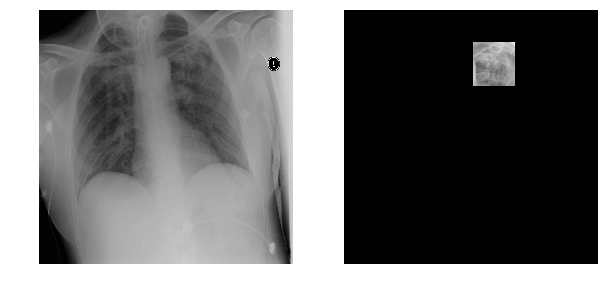

In [32]:

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)

image = dataset_train.load_image(image_id)

mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [33]:
#MODEL_DIR = os.path.join(PROJ_DIR, 'logs')
MODEL_DIR = '/home/ec2-user/SageMaker/coco/logs'
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'


In [34]:
model = modellib.MaskRCNN(mode='training', config=config_tf, model_dir=MODEL_DIR)
# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [35]:
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [36]:
epoch_time_start = time.time()
print ('epoch_time_start :', epoch_time_start)

epoch_time_start : 1590864935.9642084


In [37]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.006
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all'
            ,augmentation=augmentation)


Starting at epoch 0. LR=0.006

Checkpoint Path: /home/ec2-user/SageMaker/coco/logs/pneumonia_cocoweights_alllayers20200530T1855/mask_rcnn_pneumonia_cocoweights_alllayers_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a      






Epoch 1/5
100/100 [==============================] - 1712s 17s/step - loss: 1.2980 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.2309 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.3404 - mrcnn_mask_loss: 0.4010 - val_loss: 2.6338 - val_rpn_class_loss: 0.0465 - val_rpn_bbox_loss: 0.8362 - val_mrcnn_class_loss: 0.5891 - val_mrcnn_bbox_loss: 0.6155 - val_mrcnn_mask_loss: 0.5465

Epoch 2/5
100/100 [==============================] - 1036s 10s/step - loss: 1.1548 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.2709 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.3337 - val_loss: 3.6833 - val_rpn_class_loss: 0.0450 - val_rpn_bbox_loss: 2.0223 - val_mrcnn_class_loss: 0.5070 - val_mrcnn_bbox_loss: 0.5958 - val_mrcnn_mask_loss: 0.5132
Epoch 3/5
100/100 [==============================] - 1008s 10s/step - loss: 1.0542 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.3376 - val_loss: 2.2527 - val_rp

In [38]:
epoch_end_time = time.time() - epoch_time_start
print ('epoch_time_end :', time.time())
print ('Time taken :', epoch_end_time)

epoch_time_end : 1590871037.8040364
Time taken : 6101.83980679512


In [39]:
history = model.keras_model.history.history
print(history)

{'val_loss': [2.633778567314148, 3.683331069946289, 2.25268483877182, 2.261148455142975, 2.0736429142951964], 'val_rpn_class_loss': [0.04650613360106945, 0.04500974252820015, 0.03434320509433746, 0.03681822411715984, 0.026260319612920285], 'val_rpn_bbox_loss': [0.8362431025505066, 2.0223199033737185, 0.8139669215679168, 0.440110470354557, 0.634841300547123], 'val_mrcnn_class_loss': [0.5891028207540512, 0.5069814825057983, 0.3656417679786682, 0.5716918820142746, 0.4100093701481819], 'val_mrcnn_bbox_loss': [0.6154643017053604, 0.5958074742555618, 0.5412913352251053, 0.6258483278751373, 0.48580525517463685], 'val_mrcnn_mask_loss': [0.5464545911550522, 0.513204852938652, 0.4974339288473129, 0.5866719287633896, 0.516718966960907], 'loss': [1.2979767403006555, 1.1548450231552123, 1.0542172673344612, 1.040552704036236, 0.9427633741497994], 'rpn_class_loss': [0.026155765135772526, 0.019861991433426738, 0.015862806881777942, 0.015193049879744649, 0.01157564070308581], 'rpn_bbox_loss': [0.230871

In [40]:
#Getting the Latest model File
dir_names = next(os.walk(model.model_dir))[1]
key = config_tf.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)
print(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

['pneumonia_cocoweights_alllayers20200530T1801', 'pneumonia_cocoweights_alllayers20200530T1802', 'pneumonia_cocoweights_alllayers20200530T1855']
No weight files in /home/ec2-user/SageMaker/coco/logs/pneumonia_cocoweights_alllayers20200530T1801
Found model /home/ec2-user/SageMaker/coco/logs/pneumonia_cocoweights_alllayers20200530T1855/mask_rcnn_pneumonia_cocoweights_alllayers_0005.h5
